In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [2]:
def cargar_senal(path_csv):
    df = pd.read_csv(path_csv, sep=';')
    df.columns = [col.strip() for col in df.columns]
    return df

In [3]:
def upsample_rom(df):
    # Obtener el número total de filas (filas de datos)
    original_len = len(df)
    
    # Contar las celdas no vacías en la columna de ángulos (ROM)
    no_vacias_angulos = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].notna().sum()
    
    # Si hay valores válidos, se puede hacer upsampling
    if no_vacias_angulos == 0:
        raise ValueError("No hay valores válidos en la columna de ángulos.")
    
    # Calcular el factor de upsampling
    factor_upsampling = original_len / no_vacias_angulos
    
    # Crear el espacio de interpolación para ROM
    x_original = np.linspace(0, 1, no_vacias_angulos)
    x_new = np.linspace(0, 1, original_len)
    
    # Crear DataFrame vacío para los datos upsampled
    upsampled_df = df.copy()  # Copiar el DataFrame original para no modificar las otras columnas
    
    # Interpolación solo de la columna de ROM
    rom_col = 'angles_biceps_brachii_(right)_triceps_brachii_long_(right)'
    interpolator = interp1d(x_original, df[rom_col].dropna(), kind='cubic', fill_value='extrapolate')
    upsampled_df[rom_col] = interpolator(x_new)
    
    return upsampled_df

In [4]:
def calcular_aceleracion(df):
    rom_col = 'angles_biceps_brachii_(right)_triceps_brachii_long_(right)'
    tiempo = np.arange(len(df))  # si no tienes tiempo explícito, usamos el índice como tiempo

    velocidad = np.gradient(df[rom_col], tiempo)
    aceleracion = np.gradient(velocidad, tiempo)
    
    df['velocidad'] = velocidad
    df['aceleracion'] = aceleracion
    return df

In [5]:
def resolver_offsets_emg(df):
    for col in df.columns:
        if 'emg_muscle' in col:
            offset = df[col].mean()
            df[col] = df[col] - offset
    return df

In [6]:
def normalizar_tiempo(df):
    n = len(df)
    df['tiempo_normalizado'] = np.linspace(0, 1, n)
    return df

In [7]:
path = 'MEDICIONES_COLEGIO/2ESO/42BPM/1/advanced_mdurance-test-240835 (5).csv'
df = cargar_senal(path)
df_copy = df
df = upsample_rom(df)
df = calcular_aceleracion(df)
df = resolver_offsets_emg(df)
df = normalizar_tiempo(df)

In [8]:
df

,angles_window,angles_biceps_brachii_(right)_triceps_brachii_long_(right),emg_muscle_biceps_brachii_(right)_(µV),emg_muscle_triceps_brachii_long_(right)_(µV),velocidad,aceleracion,tiempo_normalizado
0,0.05,69.890000,-464.723845,-18.156589,-0.004234,-0.000035,0.000000
1,NaN,69.885766,-437.028845,-18.156589,-0.004270,-0.000053,0.000024
2,NaN,69.881460,-403.178845,-15.079589,-0.004340,-0.000070,0.000047
3,NaN,69.877085,-384.714845,-12.002589,-0.004410,-0.000069,0.000071
4,NaN,69.872640,-387.791845,-8.924589,-0.004479,-0.000068,0.000095
...,...,...,...,...,...,...,...
42210,NaN,87.513803,233.819155,-233.566589,-0.000931,-0.000009,0.999905
42211,NaN,87.512867,230.742155,-230.489589,-0.000941,-0.000010,0.999929
42212,NaN,87.511921,276.901155,-245.875589,-0.000951,-0.000010,0.999953
42213,NaN,87.510966,255.360155,-239.721589,-0.000961,-0.000007,0.999976


In [9]:
min_angle = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].min()
max_angle = df['angles_biceps_brachii_(right)_triceps_brachii_long_(right)'].max()
print(f"Min. angle: {min_angle}")
print(f"Max. angle: {max_angle}")

Min. angle: -73.12387262393335
Max. angle: 110.26683410751131


In [10]:
bpm = 42
segundos_por_ciclo = 60 / bpm
n = len(df)

# Si cada fila es una muestra, y asumiendo 1 muestra por ciclo:
tiempo = np.linspace(0, segundos_por_ciclo * n, n)

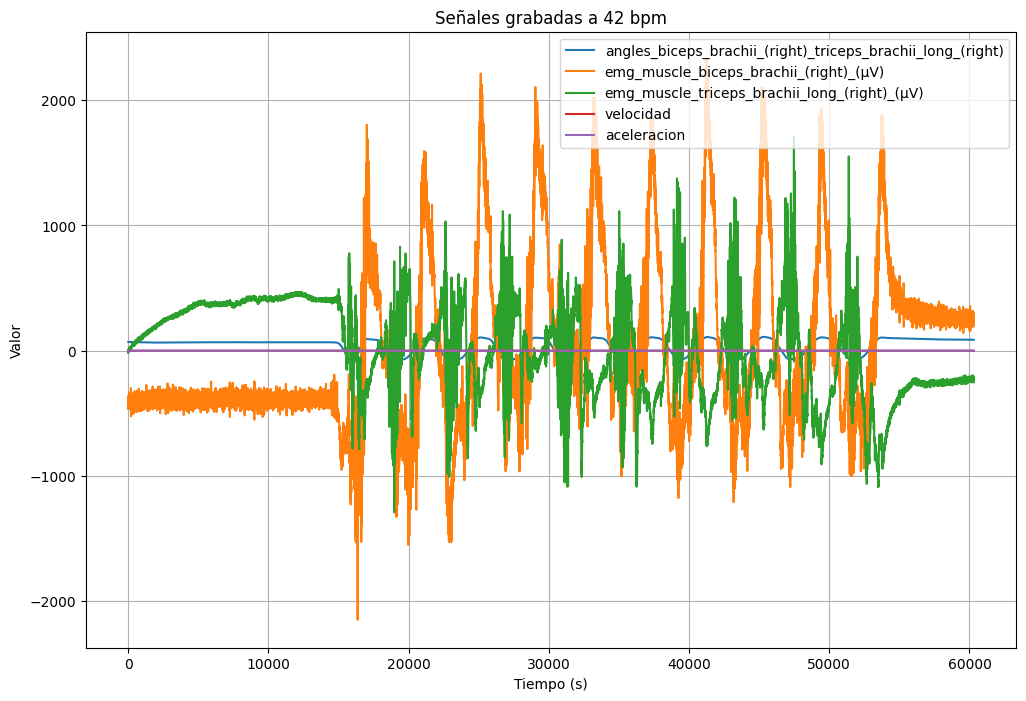

In [11]:
# Crear figura y ejes
plt.figure(figsize=(12, 8))

for col in df.columns:
    if col != 'tiempo_normalizado' and col != 'angles_window':  # Omitir columna de tiempo normalizado si quieres
        plt.plot(tiempo, df[col], label=col)

plt.xlabel('Tiempo (s)')
plt.ylabel('Valor')
plt.title('Señales grabadas a 42 bpm')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

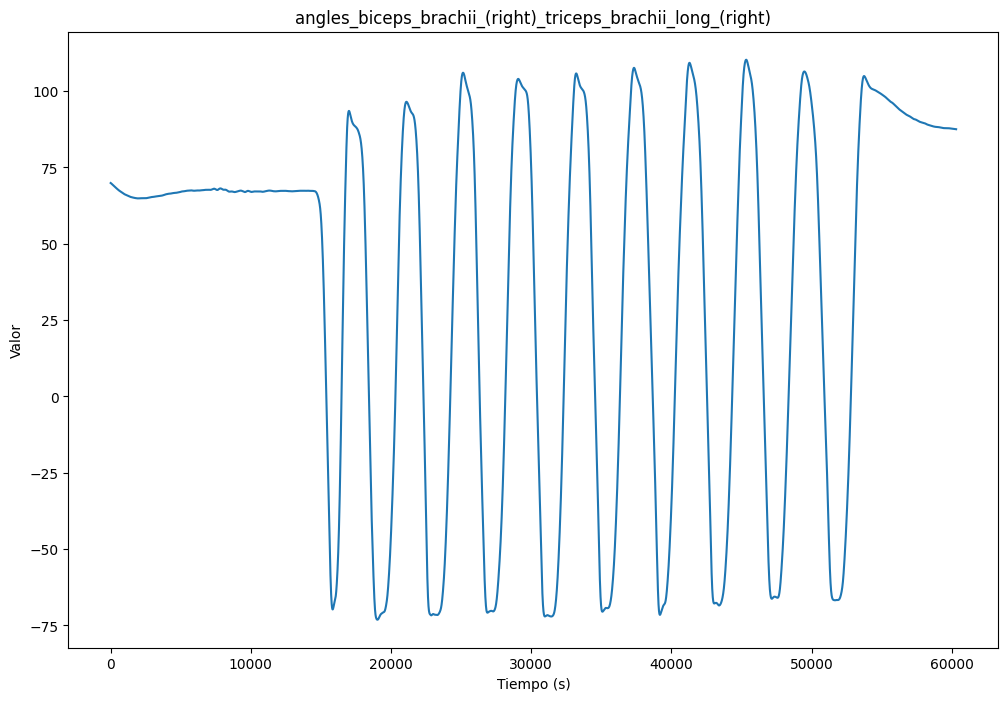

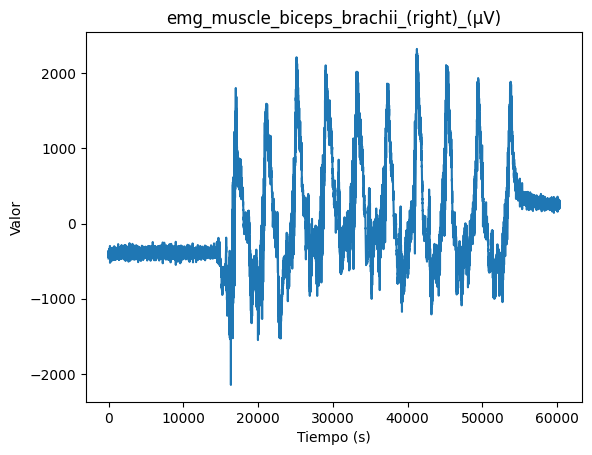

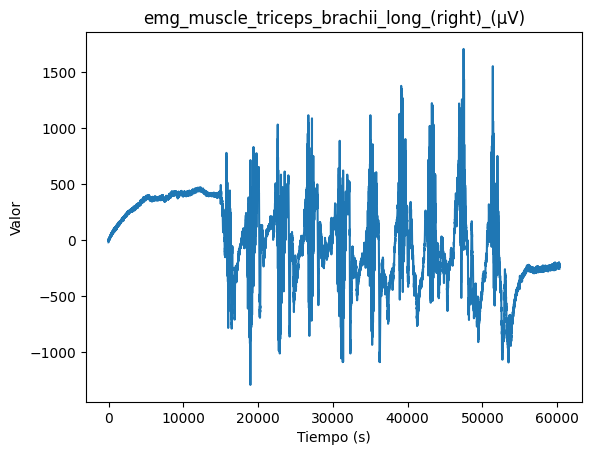

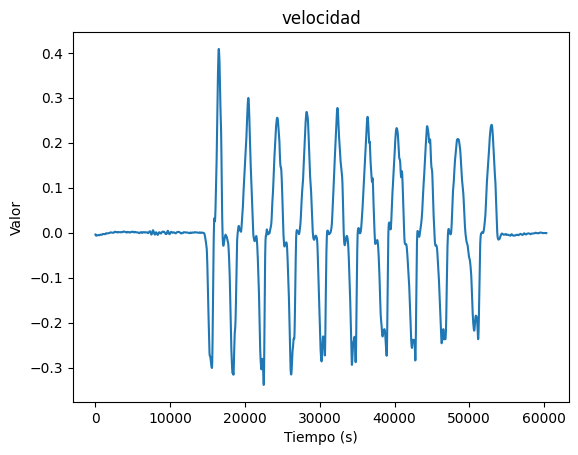

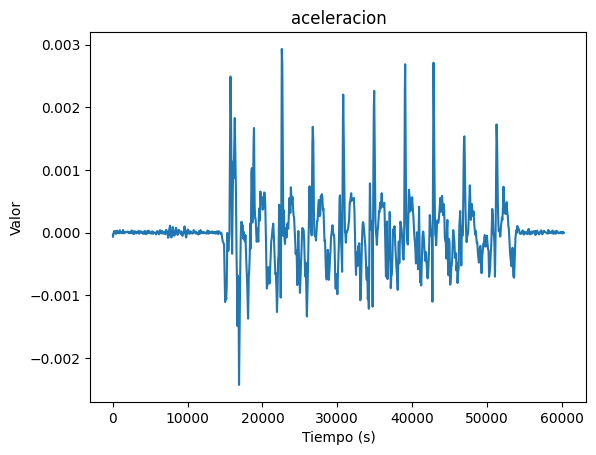

In [12]:
# Crear figura y ejes
plt.figure(figsize=(12, 8))

for col in df.columns:
    if col != 'tiempo_normalizado' and col != 'angles_window':  # Omitir columna de tiempo normalizado si quieres
        plt.plot(tiempo, df[col], label=col)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor')
        plt.title(col)
        plt.show()
        plt.close()

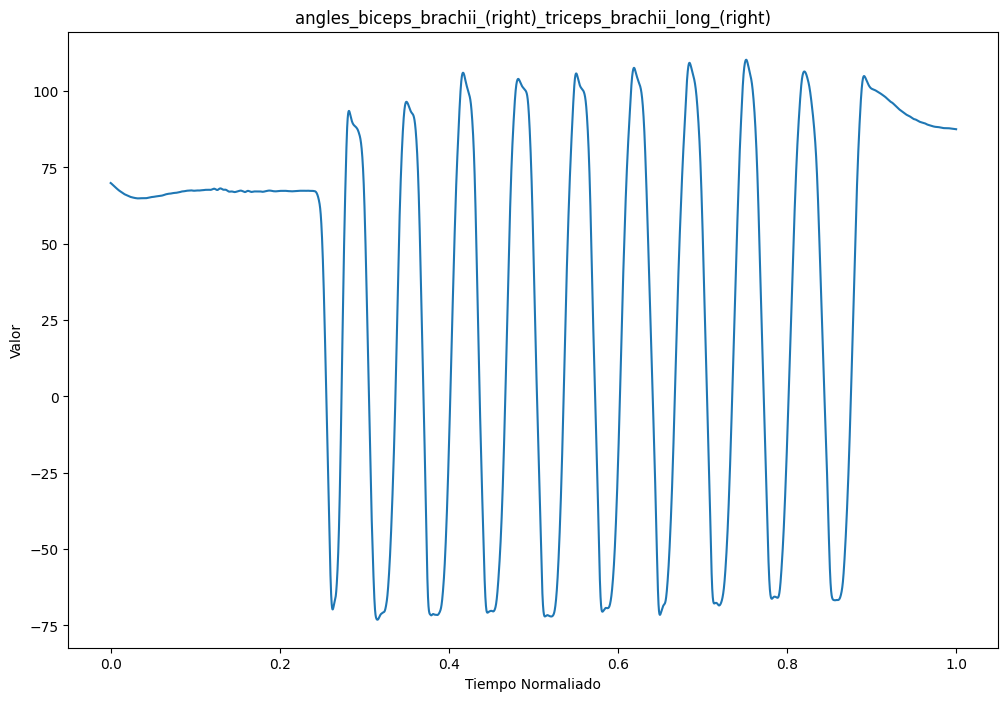

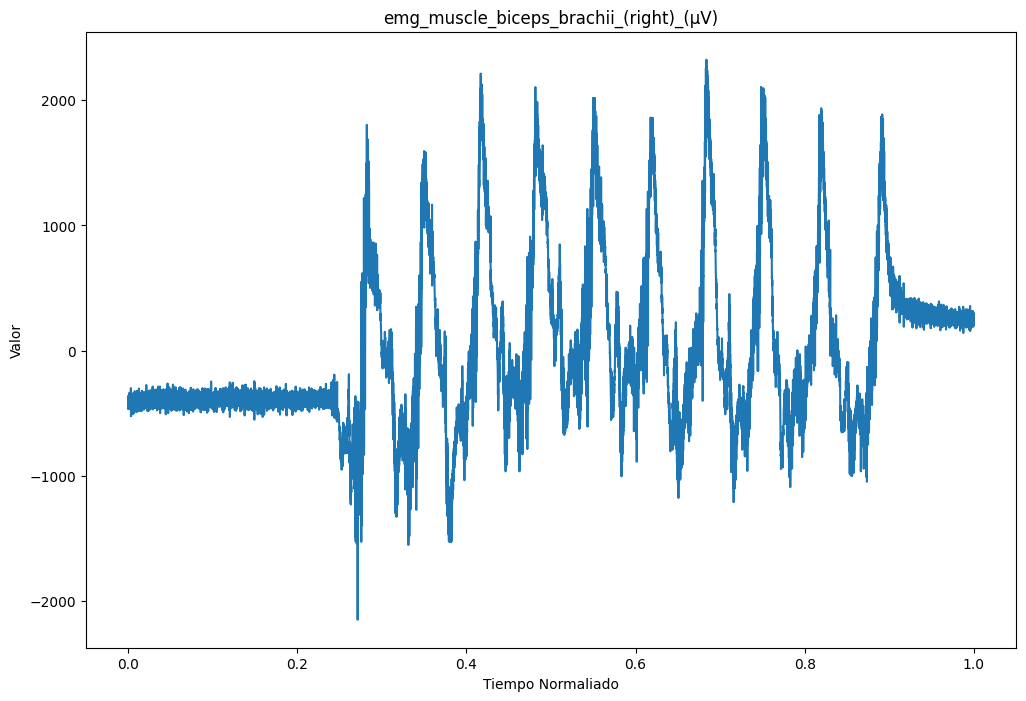

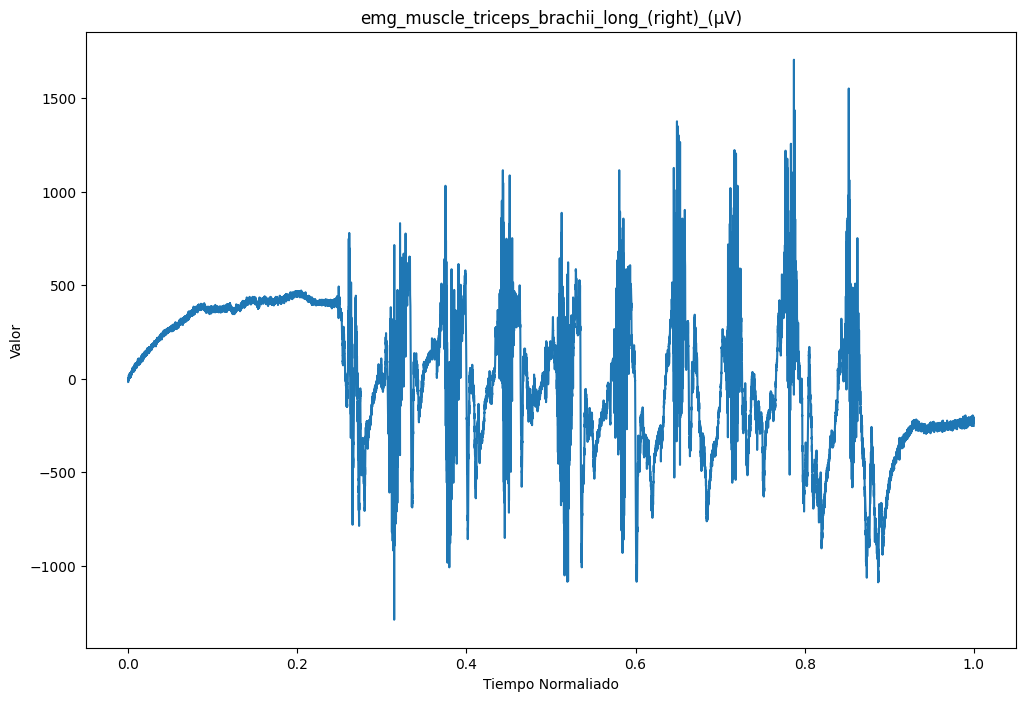

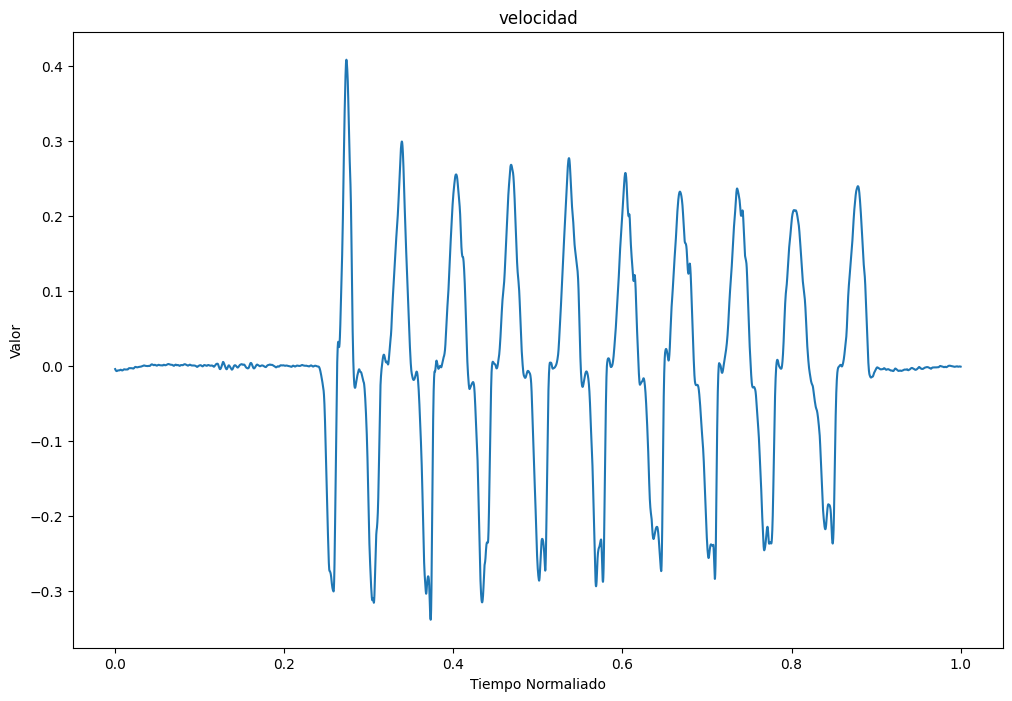

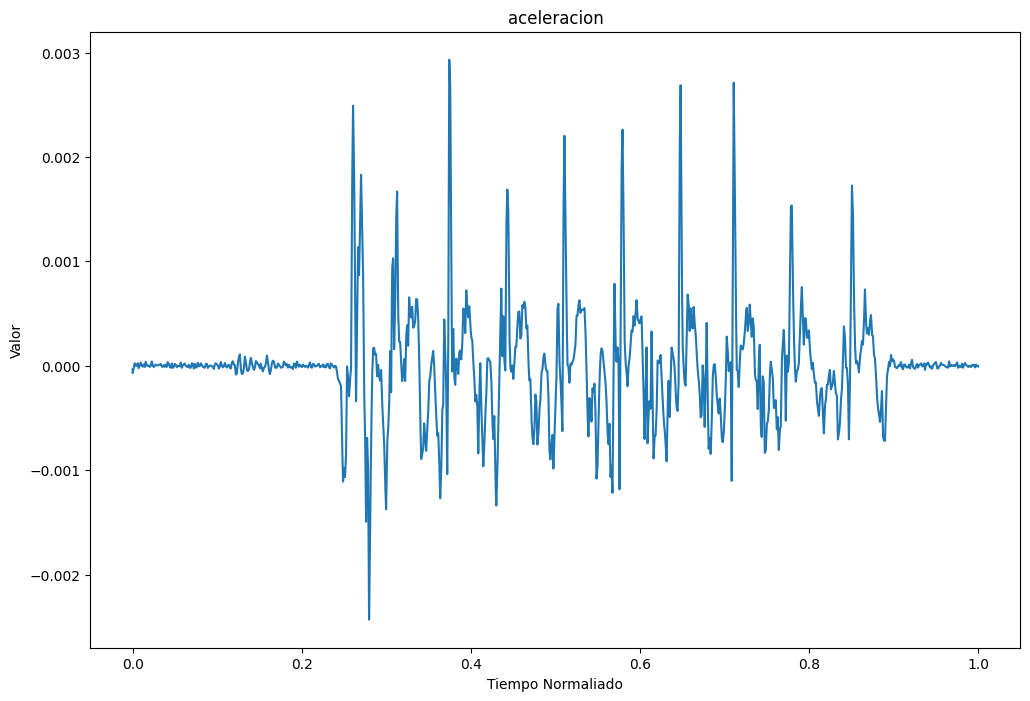

In [14]:


for col in df.columns:
    if col != 'tiempo_normalizado' and col != 'angles_window':  # Omitir columna de tiempo normalizado si quieres
        plt.figure(figsize=(12, 8))
        plt.plot(df['tiempo_normalizado'], df[col], label=col)
        plt.xlabel('Tiempo Normaliado')
        plt.ylabel('Valor')
        plt.title(col)
        plt.show()
        plt.close()